<a href="https://colab.research.google.com/github/KhuramC/Fear-Lesson-Plans/blob/master/D1/D1.1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1-Cell Amygdala Salivation Model
Before we get into 'what is fear', we will be talking about a famous example of conditioning with Pavlov's dogs. View the video below detailing the experiment.
*   STEP 1. The neurons in amygdala of dogs (and humans) fire very low normally, e.g., 0.1-0.5 Hz. However, in the state of salivation, they fire at a high rate, e.g., 5 Hz.
*   STEP 2. In the Pavlovian bell salivation conditioning paradigm (that is covered in the powerpoint and video), the neural pathway carrying the bell information to the amygdala strengthens with repeated conditioning. That is, the synaptic strength (weight) of the connection increases till the bell itself is capable of firing the amygdala(and causing salivation)
*   STEP 3. You are given a model of an amygdala neuron, with knobs to change the following: (i) synaptic strength of the connection, (ii) delay from start when the bell begins, and (iii) the duration of the bell.
##The model being used:
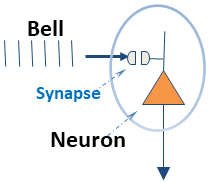

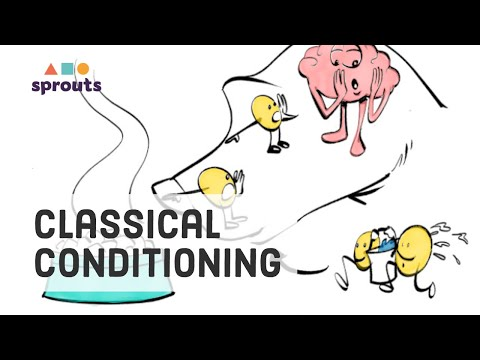

In [1]:
#@title Run cell to load video

from IPython.display import YouTubeVideo
YouTubeVideo('jd7Jdug5SRc')



---
CHALLENGE - Assume the baseline firing rate, i.e., in the absence of salivation is **0.5 Hz**. And that the firing rate when salivating is **5 Hz**. Your task is to manipulate the three knobs below to find the settings that results in a NO-SALIVATION state, and the SAILVATION state.  Report the values of the parameters bell strength, delay and duration, that you used to arrive at your results.


In [2]:
#@title Run cell to activate model
import os
import numpy as np
from os.path import normpath, sep, join

RunningInCOLAB = 'google.colab' in str(get_ipython())
print("Downloading model this will only take a min")
if RunningInCOLAB:
    !pip install ipywidgets==7.7.1 &> /dev/null
    !pip install neuron &> /dev/null
    root = 'Fear-Lesson-Plans'
    folder = 'D1'
    pathlist = normpath(os.getcwd()).split(sep)
    if pathlist[-1] != folder:
      rootidx = pathlist.index(root) if root in pathlist else -1
      if rootidx>0:
        os.chdir(join(sep,*pathlist[:rootidx]))
      !git clone https://github.com/GregGlickert/Fear-Lesson-Plans.git &> /dev/null
      os.chdir(join(root,folder))
#print(os.getcwd())
os.system('nrnivmodl modfiles') # compile modfiles. Return 0 for success, 1 for failure.

import matplotlib.pyplot as plt
from matplotlib import gridspec
from neuron import h
import ipywidgets as widgets
from ipywidgets import interactive_output,HBox,VBox,Label,Layout
from IPython.display import display
%matplotlib inline

h.load_file('stdrun.hoc')
h.load_file('PN_cells.hoc') # reads in template
cell = h.PN_C() #cell from template file

h.dt = 0.1 # time step (resolution) of the simulation in ms
h.tstop = 1800 # how long to run the simulation in ms
h.v_init= -65 # initial membrane potential in mV



#h.topology()

#pyr2pyr0 = h.pyr2pyr(soma[0](0.5))

#tone2pyr0 = h.pyr2pyr(soma[0](0.9)) # makes a syn connected to soma

stim = h.IClamp((cell.dend[0](0.9)))

#shock2pyr0 = h.pyr2pyr(soma[0](0.8))


t = h.Vector()      # Vectors are used to record data in the simulation
Soma_v = h.Vector()
#i_nmda = h.Vector()
#capoolcon = h.Vector()
#W = h.Vector()

t.record(h._ref_t)                # derefences and records data
Soma_v.record(cell.soma[0](0.5)._ref_v)
#i_nmda.record(tone2pyr0._ref_inmda)
#capoolcon.record(tone2pyr0._ref_capoolcon)
#W.record(tone2pyr0._ref_W)

def plot_variables(x_lim): # plots stuff

    #fig = plt.figure(figsize=(12,8),tight_layout=True)
    #spec = fig.add_gridspec(3, 2)
    #ax11 = fig.add_subplot(spec[0,0]); ax12 = fig.add_subplot(spec[0,1])
    #ax31 = fig.add_subplot(spec[1,:])
    #ax21 = fig.add_subplot(spec[2,0]); ax22 = fig.add_subplot(spec[2,1])

    #gs_kw = dict(width_ratios=[1,1], height_ratios=[2,1,2])
    #fig, ax = plt.subplot_mosaic([['upper left', 'upper right'],
    #                              ['middle center','middle center'],
    #                              ['lower left', 'lower right']],
    #                          gridspec_kw=gs_kw, figsize=(12, 8),
    #                          constrained_layout=True)

    fig = plt.figure(figsize=(15, 5),tight_layout=True)
    gs = gridspec.GridSpec(1, 1, width_ratios=[1],height_ratios=[1])


    ax0 = plt.subplot(gs[0,0])
    #ax2 = plt.subplot(gs[0,:])


    ax0.plot(t, Soma_v)
    ax0.legend(['Soma Vm'])
    ax0.set_ylabel('Voltage (mV)')
    ax0.set_xlabel('Time (ms)')
    ax0.set_title('1-Cell Amygdala Salivation Firing Rate')
    ax0.set_ylim(-80,50)
    ax0.set_xlim(0,x_lim)

    #ax2.set_ylabel('Inputs')
    #ax2.set_xlabel("Time (ms)")
    #if tone_freq == 0:
    #    tone = np.arange(3000,4000,1)
    #else:
    #    tone = np.arange(100,1750,1000/tone_freq)
    #tone_index = []
    #for i in range(len(tone)):
    #    tone_index.append(1)

    #ax2.scatter(tone,tone_index,label='Tone')
    #if tone_freq == 0:
    #    major_ticks = np.arange(3000,4000,1)
    #else:
    #    major_ticks = np.arange(100, 1750, 1000/tone_freq)
    #y_ticks = np.arange(1,3,1)
    #ax2.set_xticks(major_ticks)
    #ax2.set_yticks(y_ticks)
    #ax2.legend()
    #n = 4  # Keeps every 4th tick label
    #[l.set_visible(False) for (i,l) in enumerate(ax2.xaxis.get_ticklabels()) if i % n != 0]
    #ax2.grid()
    #ax2.set_xlim(0,1800)
    #ax2.set_ylim(0.8,1)

    plt.show()

def activemodel(clamp_delay, clamp_dur, clamp_amp):

    stim.amp = clamp_amp/10
    stim.delay = clamp_delay
    stim.dur = clamp_dur
    if(clamp_dur+clamp_delay > 1800):
      h.tstop = clamp_dur+clamp_delay+100
    else:
      h.tstop = 1800
    x_lim = h.tstop


    h.run()
    plt.close('all')
    plot_variables(x_lim)

clamp_delay = 500
diam = 30
clamp_dur = 1000
clamp_amp = 0.1


w_reset = widgets.Button(description='Reset',icon='history',button_style='primary')
w_solution = widgets.Button(description = 'Show Salivation', icon = 'history', button_style = 'primary')
w_clamp_delay = widgets.FloatSlider(value=clamp_delay, min=0, max=1500, step=10,layout=Layout(width='20%', height='15px'))
w_clamp_dur = widgets.FloatSlider(value=clamp_dur, min=0, max=2000, step=10,layout=Layout(width='20%', height='15px'))
w_clamp_amp = widgets.FloatSlider(value=clamp_amp, min=0, max=1, step=0.01,layout=Layout(width='20%', height='15px',readout_format='.3f'))


def reset_default(*args):
    w_clamp_delay.value = clamp_delay
    w_clamp_dur.value = clamp_dur
    w_clamp_amp.value = clamp_amp

w_reset.on_click(reset_default)

def show_solution(*args):
  w_clamp_delay.value = clamp_delay
  w_clamp_dur.value = clamp_dur
  w_clamp_amp.value = 0.38

w_solution.on_click(show_solution)

labels = ['Bell Syn. Strength','Bell Delay(ms)', 'Bell Duration(ms)']
Labels = [Label(L) for L in labels]

ui = VBox([ HBox([w_reset,w_solution]),
           HBox([Labels[0],w_clamp_amp]),
           HBox([Labels[1],w_clamp_delay]),
           HBox([Labels[2], w_clamp_dur])])
out = interactive_output(activemodel, {'clamp_delay': w_clamp_delay, 'clamp_dur': w_clamp_dur,
                                       'clamp_amp': w_clamp_amp})

display(ui,out)

Output()

# 1-Cell Amygdala Fear Model
This Colab illustrates 'what is fear?'. In mammals, a region of the brain called the 'amygdala' has been found to be the fear center. For instance, you have two almond sized amygdalas in the two hemispheres of your brain.
*   STEP 1. The neurons in amygdala of rodents (and humans) fire very low normally, e.g., 0.1-0.5 Hz. However, in the state of fear, they fire at a very high rate, e.g., 7 Hz.
*   STEP 2. In the Pavlovian tone fear conditioning paradigm (that is covered in the powerpoint), the neural pathway carrying the tone information to the amygdala strengthens with repeated conditioning. That is, the synaptic strength (weight) of the connection increases till the tone itself is capable of firing the amygdala.
*   STEP 3. You are given a model of an amygdala neuron, with knobs to change the following: (i) synaptic strength of the connection, (ii) delay from start when the tone begins, and (iii) the duration of the tone.



# The model being used:

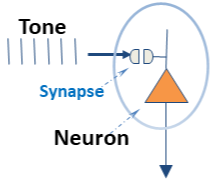

---

CHALLENGE - Assume the baseline firing rate, i.e., in the absence of fear is **0.5 Hz**. And that the firing rate when fearful is **7 Hz**. Your task is to manipulate the three knobs below to find the settings that results in a NO-FEAR state, and the FEAR state.  Report the values of the parameters tone strength, delay and duration, that you used to arrive at your results.

In [3]:
#@title Run cell to activate model
import os
import numpy as np
from os.path import normpath, sep, join

RunningInCOLAB = 'google.colab' in str(get_ipython())
print("Downloading model this will only take a min")
if RunningInCOLAB:
    !pip install ipywidgets==7.7.1 &> /dev/null
    !pip install neuron &> /dev/null
    root = 'Fear-Lesson-Plans'
    folder = 'D1'
    pathlist = normpath(os.getcwd()).split(sep)
    if pathlist[-1] != folder:
      rootidx = pathlist.index(root) if root in pathlist else -1
      if rootidx>0:
        os.chdir(join(sep,*pathlist[:rootidx]))
      !git clone https://github.com/GregGlickert/Fear-Lesson-Plans.git &> /dev/null
      os.chdir(join(root,folder))
#print(os.getcwd())
os.system('nrnivmodl modfiles') # compile modfiles. Return 0 for success, 1 for failure.

import matplotlib.pyplot as plt
from matplotlib import gridspec
from neuron import h
import ipywidgets as widgets
from ipywidgets import interactive_output,HBox,VBox,Label,Layout
from IPython.display import display
%matplotlib inline

h.load_file('stdrun.hoc')
h.load_file('PN_cells.hoc') # reads in template
cell = h.PN_C() #cell from template file

h.dt = 0.1 # time step (resolution) of the simulation in ms
h.tstop = 1800 # how long to run the simulation in ms
h.v_init= -65 # initial membrane potential in mV



#h.topology()

#pyr2pyr0 = h.pyr2pyr(soma[0](0.5))

#tone2pyr0 = h.pyr2pyr(soma[0](0.9)) # makes a syn connected to soma

stim = h.IClamp((cell.dend[0](0.9)))

#shock2pyr0 = h.pyr2pyr(soma[0](0.8))


t = h.Vector()      # Vectors are used to record data in the simulation
Soma_v = h.Vector()
#i_nmda = h.Vector()
#capoolcon = h.Vector()
#W = h.Vector()

t.record(h._ref_t)                # derefences and records data
Soma_v.record(cell.soma[0](0.5)._ref_v)
#i_nmda.record(tone2pyr0._ref_inmda)
#capoolcon.record(tone2pyr0._ref_capoolcon)
#W.record(tone2pyr0._ref_W)

def plot_variables(x_lim): # plots stuff

    #fig = plt.figure(figsize=(12,8),tight_layout=True)
    #spec = fig.add_gridspec(3, 2)
    #ax11 = fig.add_subplot(spec[0,0]); ax12 = fig.add_subplot(spec[0,1])
    #ax31 = fig.add_subplot(spec[1,:])
    #ax21 = fig.add_subplot(spec[2,0]); ax22 = fig.add_subplot(spec[2,1])

    #gs_kw = dict(width_ratios=[1,1], height_ratios=[2,1,2])
    #fig, ax = plt.subplot_mosaic([['upper left', 'upper right'],
    #                              ['middle center','middle center'],
    #                              ['lower left', 'lower right']],
    #                          gridspec_kw=gs_kw, figsize=(12, 8),
    #                          constrained_layout=True)

    fig = plt.figure(figsize=(15, 5),tight_layout=True)
    gs = gridspec.GridSpec(1, 1, width_ratios=[1],height_ratios=[1])


    ax0 = plt.subplot(gs[0,0])
    #ax2 = plt.subplot(gs[0,:])


    ax0.plot(t, Soma_v, color = 'red')
    ax0.legend(['Soma Vm'])
    ax0.set_ylabel('Voltage (mV)')
    ax0.set_xlabel('Time (ms)')
    ax0.set_title('1-Cell Amygdala Fear Firing Rate')
    ax0.set_ylim(-80,50)
    ax0.set_xlim(0,x_lim)

    #ax2.set_ylabel('Inputs')
    #ax2.set_xlabel("Time (ms)")
    #if tone_freq == 0:
    #    tone = np.arange(3000,4000,1)
    #else:
    #    tone = np.arange(100,1750,1000/tone_freq)
    #tone_index = []
    #for i in range(len(tone)):
    #    tone_index.append(1)

    #ax2.scatter(tone,tone_index,label='Tone')
    #if tone_freq == 0:
    #    major_ticks = np.arange(3000,4000,1)
    #else:
    #    major_ticks = np.arange(100, 1750, 1000/tone_freq)
    #y_ticks = np.arange(1,3,1)
    #ax2.set_xticks(major_ticks)
    #ax2.set_yticks(y_ticks)
    #ax2.legend()
    #n = 4  # Keeps every 4th tick label
    #[l.set_visible(False) for (i,l) in enumerate(ax2.xaxis.get_ticklabels()) if i % n != 0]
    #ax2.grid()
    #ax2.set_xlim(0,1800)
    #ax2.set_ylim(0.8,1)

    plt.show()

def activemodel(clamp_delay, clamp_dur, clamp_amp):

    stim.amp = clamp_amp/10
    stim.delay = clamp_delay
    stim.dur = clamp_dur
    if(clamp_dur+clamp_delay > 1800):
      h.tstop = clamp_dur+clamp_delay+100
    else:
      h.tstop = 1800
    x_lim = h.tstop


    h.run()
    plt.close('all')
    plot_variables(x_lim)

clamp_delay = 500
diam = 30
clamp_dur = 1000
clamp_amp = 0.1


w_reset = widgets.Button(description='Reset',icon='history',button_style='primary')
w_solution = widgets.Button(description = 'Show Fear', icon = 'history', button_style = 'primary')
w_clamp_delay = widgets.FloatSlider(value=clamp_delay, min=0, max=1500, step=10,layout=Layout(width='20%', height='15px'))
w_clamp_dur = widgets.FloatSlider(value=clamp_dur, min=0, max=2000, step=10,layout=Layout(width='20%', height='15px'))
w_clamp_amp = widgets.FloatSlider(value=clamp_amp, min=0, max=1, step=0.01,layout=Layout(width='20%', height='15px',readout_format='.3f'))


def reset_default(*args):
    w_clamp_delay.value = clamp_delay
    w_clamp_dur.value = clamp_dur
    w_clamp_amp.value = clamp_amp

w_reset.on_click(reset_default)

def show_solution(*args):
  w_clamp_delay.value = clamp_delay
  w_clamp_dur.value = clamp_dur
  w_clamp_amp.value = 0.54

w_solution.on_click(show_solution)

labels = ['Tone Syn. Strength','Tone Delay(ms)', 'Tone Duration(ms)']
Labels = [Label(L) for L in labels]

ui = VBox([ HBox([w_reset,w_solution]),
           HBox([Labels[0],w_clamp_amp]),
           HBox([Labels[1],w_clamp_delay]),
           HBox([Labels[2], w_clamp_dur])])
out = interactive_output(activemodel, {'clamp_delay': w_clamp_delay, 'clamp_dur': w_clamp_dur,
                                       'clamp_amp': w_clamp_amp})

display(ui,out)

Output()